In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))

from change_of_parameters import omega_CDM_to_luisa, F_H, F_H_prime
from constants import LAMBDA, L, OMEGA_R_0, KAPPA

from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
from scipy.integrate import simps, solve_ivp
from scipy.linalg import sqrtm
import numpy as np

from seaborn import heatmap
import pandas as pd
import emcee

import time

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hubble_parameter(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter as a function of redshift.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(z, Hs, label=f'Hubble Parameter ({model_name} Model)', color='blue', linewidth=2)

    # Enhancements
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    plt.title('Hubble Parameter vs Redshift', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')  # Optional: log scale for better visualization
    plt.xscale('log')  # Optional: log scale for better visualization
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.tight_layout()

    # Show plot
    plt.show()


def plot_hubble_parameter_subplots(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter and the integrand 1/(H(z)*(1+z)) as subplots.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    # Calculate the integrand
    integrand = 1 / (Hs * (1 + z))

    # Create a DataFrame for Seaborn
    import pandas as pd
    data = pd.DataFrame({'Redshift (z)': z, 'Hubble Parameter (H(z))': Hs, 'Integrand': integrand})

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Hubble parameter
    sns.lineplot(ax=axes[0], data=data, x='Redshift (z)', y='Hubble Parameter (H(z))', label=f'Hubble Parameter ({model_name} Model)', color='blue')
    axes[0].set_xlabel('Redshift (z)', fontsize=14)
    axes[0].set_ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    axes[0].set_title('Hubble Parameter vs Redshift', fontsize=16)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].set_yscale('log')  # Optional: log scale for better visualization
    axes[0].set_xscale('log')  # Optional: log scale for better visualization
    axes[0].minorticks_on()
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].tick_params(axis='both', which='minor', labelsize=10)

    # Plot integrand
    sns.lineplot(ax=axes[1], data=data, x='Redshift (z)', y='Integrand', label='Integrand 1/(H(z)*(1+z))', color='green')
    axes[1].set_xlabel('Redshift (z)', fontsize=14)
    axes[1].set_ylabel('Integrand 1/(H(z)*(1+z))', fontsize=14)
    axes[1].set_title('Integrand vs Redshift', fontsize=16)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].set_yscale('log')  # Optional: log scale for better visualization
    axes[1].set_xscale('log')  # Optional: log scale for better visualization
    axes[1].minorticks_on()
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='minor', labelsize=10)

    plt.tight_layout()
    plt.show()


In [3]:
def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar],model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    L_bar, b, H0 = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    #zs_int = np.logspace(np.log10(initial_z), np.log10(final_z), num_z_points)
    
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [4]:
discard=0
thin=1

os.chdir(path_data)
print(path_data)

samples_lcdm = emcee.backends.HDFBackend(os.path.join('sample_LCDM_PPS_CC_3params', 'sample_LCDM_PPS_CC_3params.h5'))
samples_beta = emcee.backends.HDFBackend(os.path.join('L=0.90','sample_BETA_PPS_CC_3params', 'sample_BETA_PPS_CC_3params.h5'))
samples_gila = emcee.backends.HDFBackend(os.path.join('L=0.90','sample_GILA_PPS_CC_3params', 'sample_GILA_PPS_CC_3params.h5'))

#nwalkers, ndim = reader_lcdm.shape #Number of walkers and parameters
flat_samples_beta = samples_beta.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila = samples_gila.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_lcdm = samples_lcdm.get_chain(discard=discard, flat=True, thin=thin)

/home/matias/Documents/Repos/GILA-output/paper


In [5]:
omega_r = 2.47e-5 
L_bar = 0.90

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

#z = np.linspace(0, 10, int(10e3))
z = np.linspace(0, 1000, int(10e3))
#z = np.logspace(-3, 3, int(10e3))



[0.00000000e+00 1.00010001e-01 2.00020002e-01 ... 9.99799980e+02
 9.99899990e+02 1.00000000e+03]


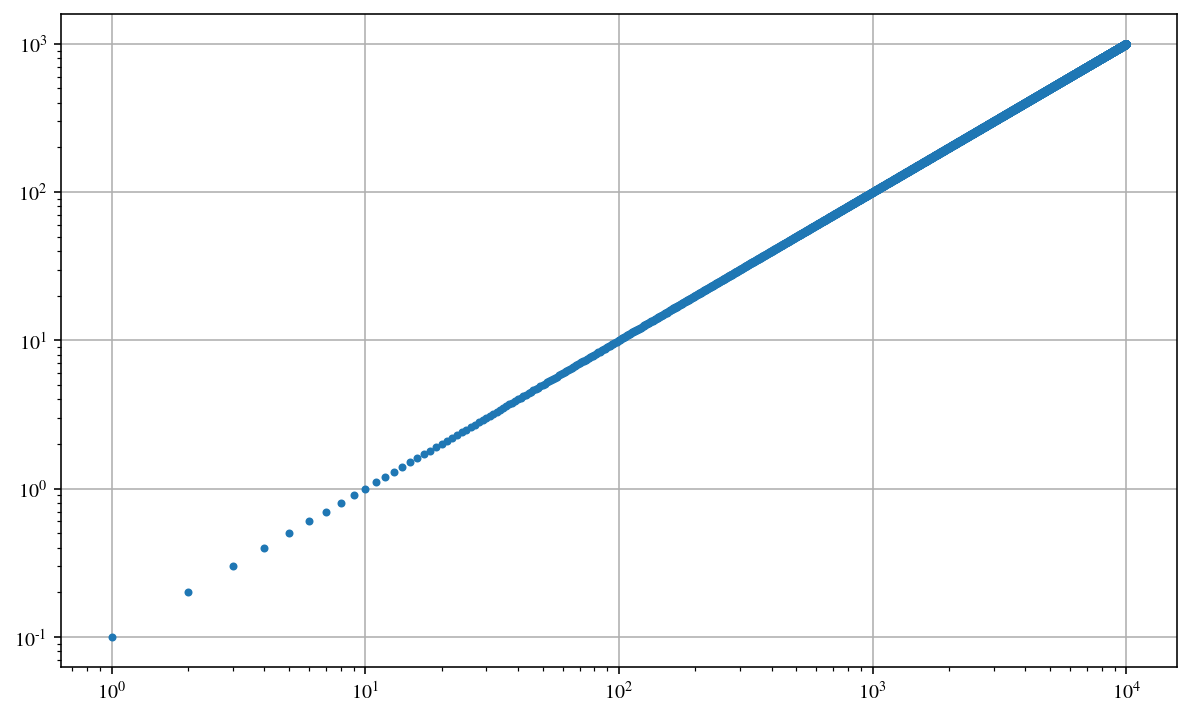

In [6]:
print(z)

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(z,'.')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [7]:
#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
omega_m = flat_samples_lcdm[:,1]
H0 = flat_samples_lcdm[:,2]

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
aou_lcdm = np.zeros(len(H0))

def aou_lcdm_calc(z, H0, Omega_r_lcdm, Omega_m_lcdm, Omega_L_lcdm):
    Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
    return inv_Hub_to_Gyr * simps((Hubble * (1+z))**(-1), z)
    #return inv_Hub_to_Gyr * simps(1 / (Hubble * (1+z)), z)

for i in range(len(aou_lcdm)):
    aou_lcdm[i] = aou_lcdm_calc(z, H0[i], Omega_r_lcdm[i], Omega_m_lcdm[i], Omega_L_lcdm[i])

0.16290042980084599 72.18797371868


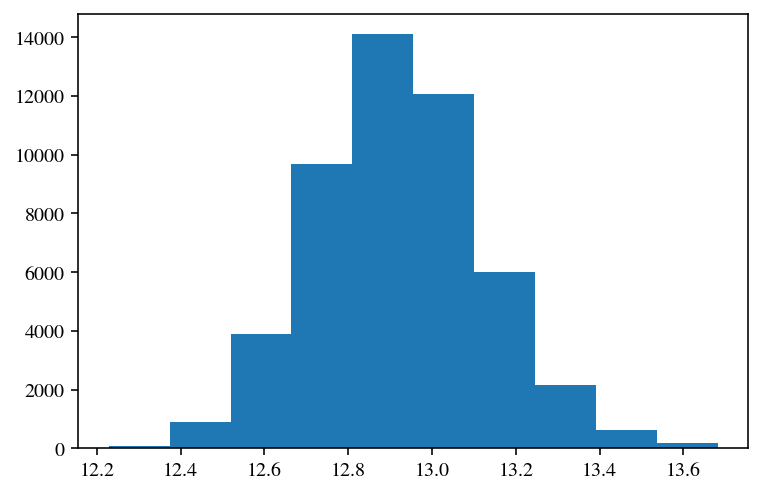

In [8]:
plt.hist(aou_lcdm)

omega_m = np.mean(flat_samples_lcdm[:,1])
H0 = np.mean(flat_samples_lcdm[:,2])

print(omega_m, H0)

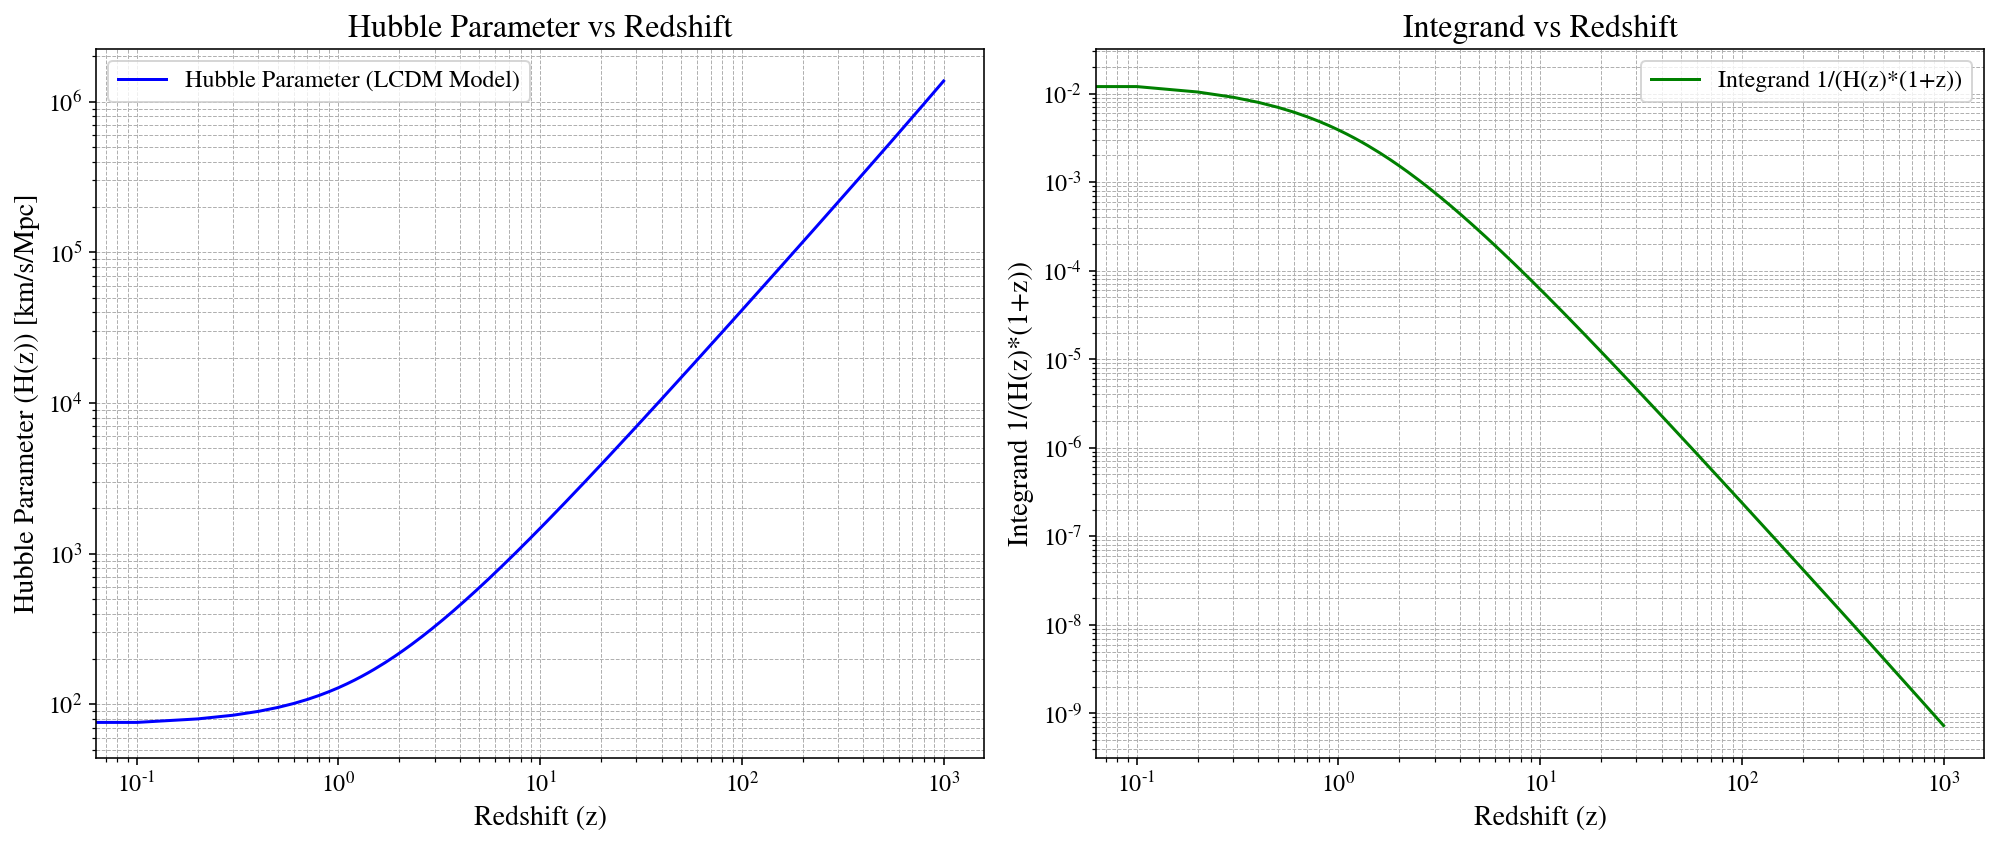

In [9]:
#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
omega_m = np.mean(flat_samples_lcdm[:,1])
H0 = np.mean(flat_samples_lcdm[:,2])

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
#aou_lcdm = np.zeros(len(H0))

Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
plot_hubble_parameter_subplots(z, Hubble, model_name='LCDM')

In [10]:
import numpy as np
from scipy.integrate import quad
from scipy.integrate import simps


# Constants
omega_r = 2.47e-5 

omega_m = np.mean(flat_samples_lcdm[:,1])
H0 = np.mean(flat_samples_lcdm[:,2])

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

Gyr_to_second = 3.1536e16
Mpc_to_km = 3.0857e19
inv_Hub_to_Gyr = Mpc_to_km / Gyr_to_second

# Define the Hubble parameter as a function of a
def H(z):
    return H0 * np.sqrt(Omega_r_lcdm* (1+z)**4 + Omega_m_lcdm* (1+z)**(3) + Omega_L_lcdm)

# Define the integrand as a function of z
def integrand(z):
    return 1 / ((1 + z) * H(z))

# Define the limits of integration
z_i = 0    # Initial redshift
z_f = 1e3  # Final redshift

# Perform the integration using quad
age_of_universe_quad, _ = quad(integrand, z_i, z_f)
age_of_universe_quad_Gyr = age_of_universe_quad * inv_Hub_to_Gyr

# Perform the integration using the trapezoidal rule
z_values = np.linspace(z_i, z_f, 100000)
integrand_values = integrand(z_values)
age_of_universe_trapz = np.trapz(integrand_values, z_values)
age_of_universe_trapz_Gyr = age_of_universe_trapz * inv_Hub_to_Gyr

age_of_universe_simps = simps(integrand_values, z_values)
age_of_universe_simps_Gyr = age_of_universe_simps * inv_Hub_to_Gyr


print(f"Age of the universe using quad: {age_of_universe_quad_Gyr:.2f} Gyr")
print(f"Age of the universe using trapezoidal rule: {age_of_universe_trapz_Gyr:.2f} Gyr")
print(f"Age of the universe using simpson rule: {age_of_universe_simps_Gyr:.2f} Gyr")

Age of the universe using quad: 12.91 Gyr
Age of the universe using trapezoidal rule: 12.91 Gyr
Age of the universe using simpson rule: 12.91 Gyr


In [11]:
#BETA MODEL
#M_abs = flat_samples_beta[:,0]
beta = flat_samples_beta[:,1]
H0 = flat_samples_beta[:,2]

aou_beta = np.zeros(1000)

for i in range(len(aou_beta)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    try:
        z_final, Hs_final = integrator_GILA(physical_params,model='BETA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1]) #3 para z=1000
        aou_beta[i] = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)    
        #aou_beta[i] = inv_Hub_to_Gyr * simps(1 / (Hs_final * (1+z_final)), z_final)    
    except Exception as e:
        # If integration fails, reject the step
        aou_beta[i] = 0

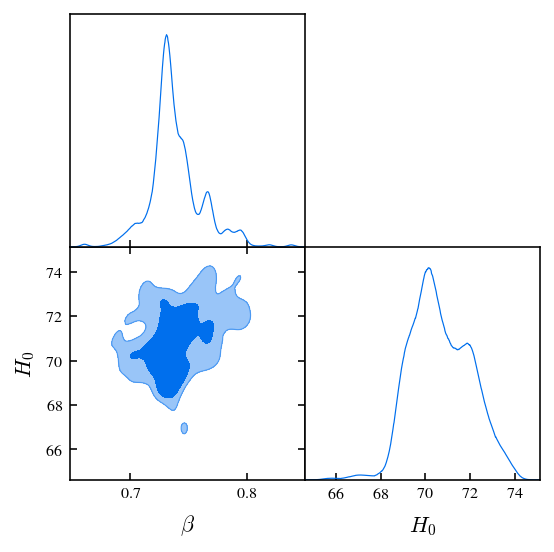

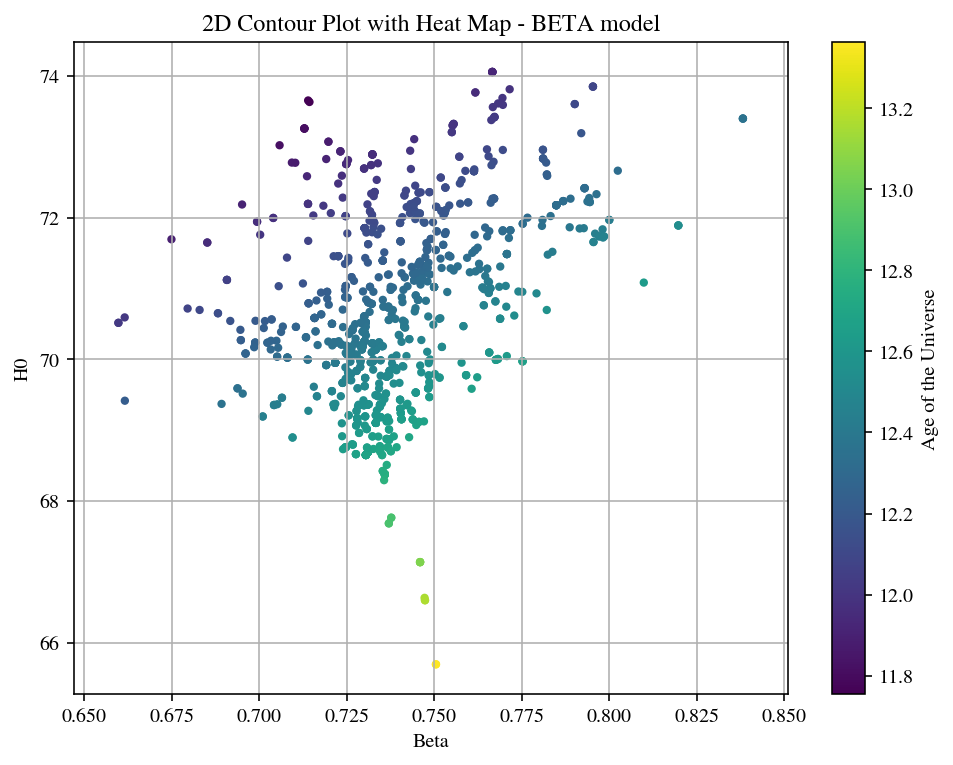

In [12]:
# Assuming flat_samples_beta contains the MCMC samples for beta and H0
beta_samples = flat_samples_beta[:, 1][:1000]
H0_samples = flat_samples_beta[:, 2][:1000]
ages = aou_beta

# Create MCSamples object for getdist
samples = MCSamples(samples=np.vstack([beta_samples, H0_samples]).T, names=['beta', 'H0'], labels=['\\beta', 'H_0'])

# Create a 2D contour plot
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True)

# Scatter plot with heat map
plt.figure(figsize=(8, 6))
plt.scatter(beta_samples, H0_samples, c=ages, cmap='viridis', s=10)
plt.colorbar(label='Age of the Universe')
plt.xlabel('Beta')
plt.ylabel('H0')
plt.title('2D Contour Plot with Heat Map - BETA model')
plt.grid(True)
plt.show()

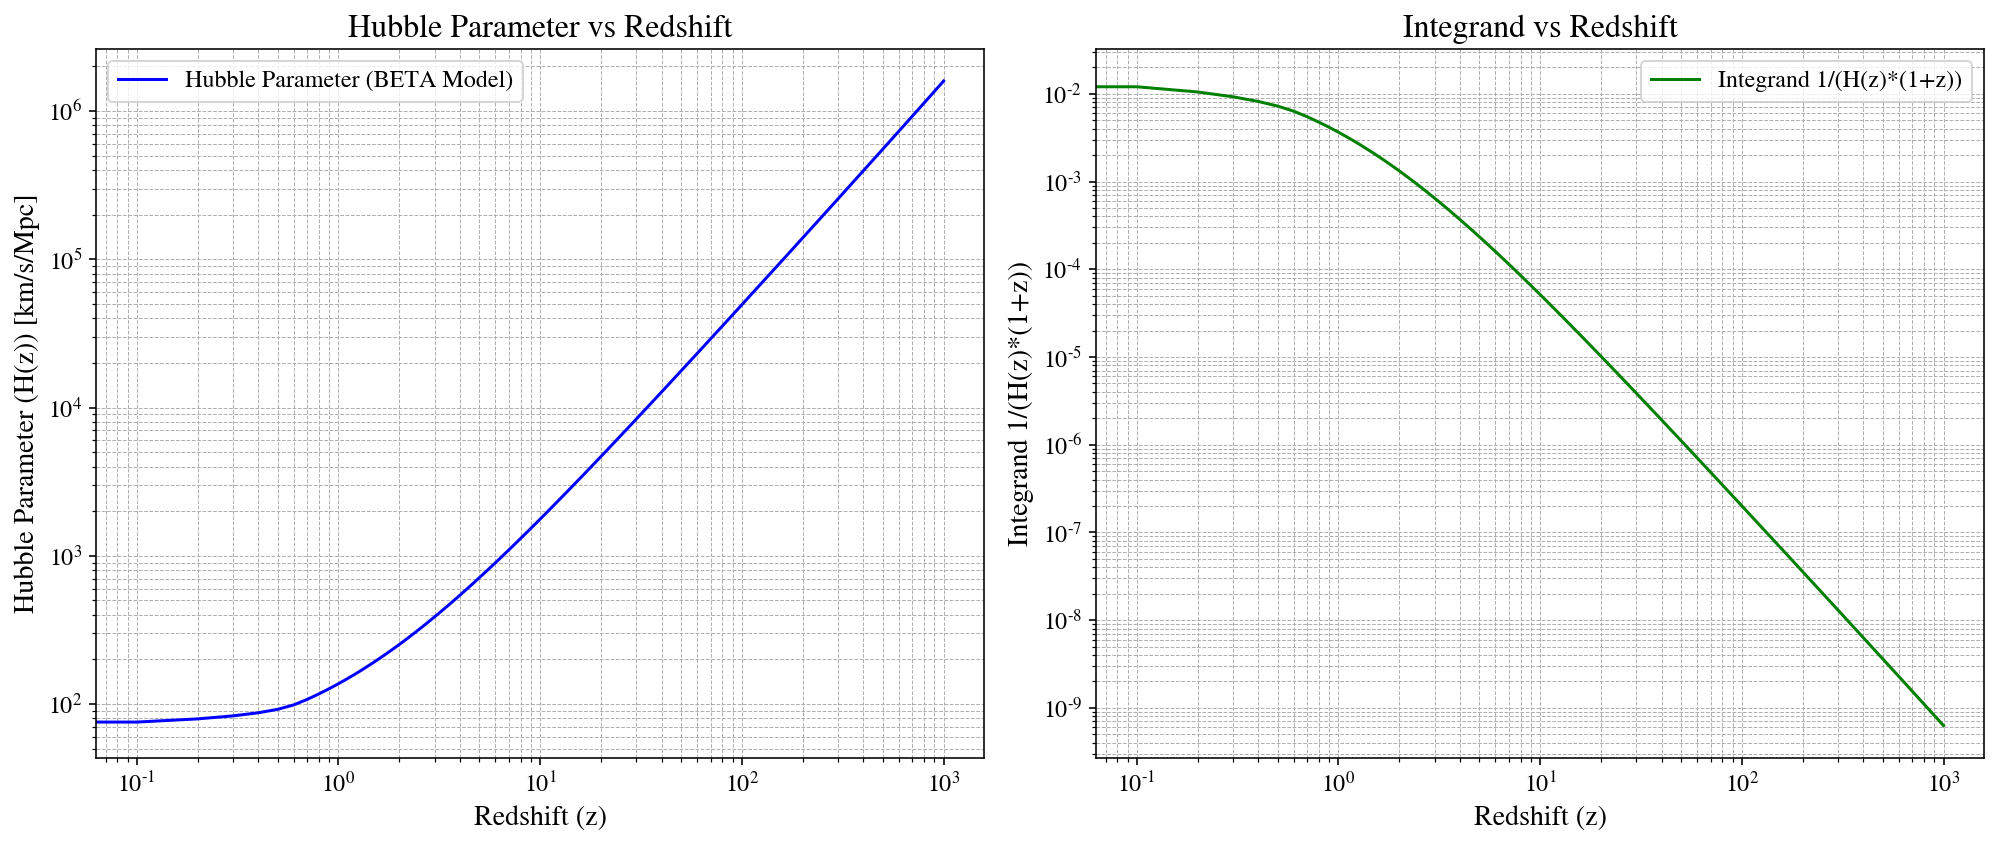

In [13]:
#BETA MODEL
#M_abs = flat_samples_beta[:,0]
beta = np.mean(flat_samples_beta[:,1])
H0 = np.mean(flat_samples_beta[:,2])

physical_params =  [L_bar, beta, H0] 
#physical_params =  [0.90, 0.3, 72] 
z_final, Hs_final = integrator_GILA(physical_params,model='BETA', num_z_points=int(len(z)),
                                    initial_z=z[0], final_z=z[-1]) #3 para z=1000

plot_hubble_parameter_subplots(z_final, Hs_final, model_name='BETA')

In [14]:
#GILA MODEL
#M_abs = flat_samples_gila[:,0]
beta = flat_samples_gila[:,1]
H0 = flat_samples_gila[:,2]

aou_gila = np.zeros(1000)

for i in range(len(aou_gila)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    try:
        z_final, Hs_final = integrator_GILA(physical_params,model='GILA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1]) #3 para z=1000
        aou_gila[i] = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)    
        #aou_gila[i] = inv_Hub_to_Gyr * simps(1 / (Hs_final * (1+z_final)), z_final)    
    except Exception as e:
        # If integration fails, reject the step
        aou_gila[i] = 0


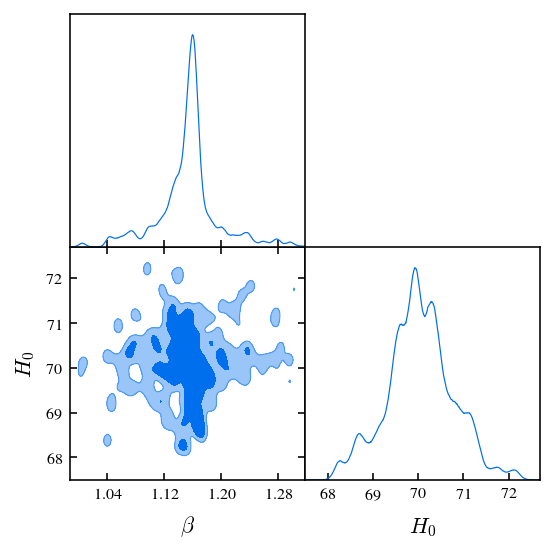

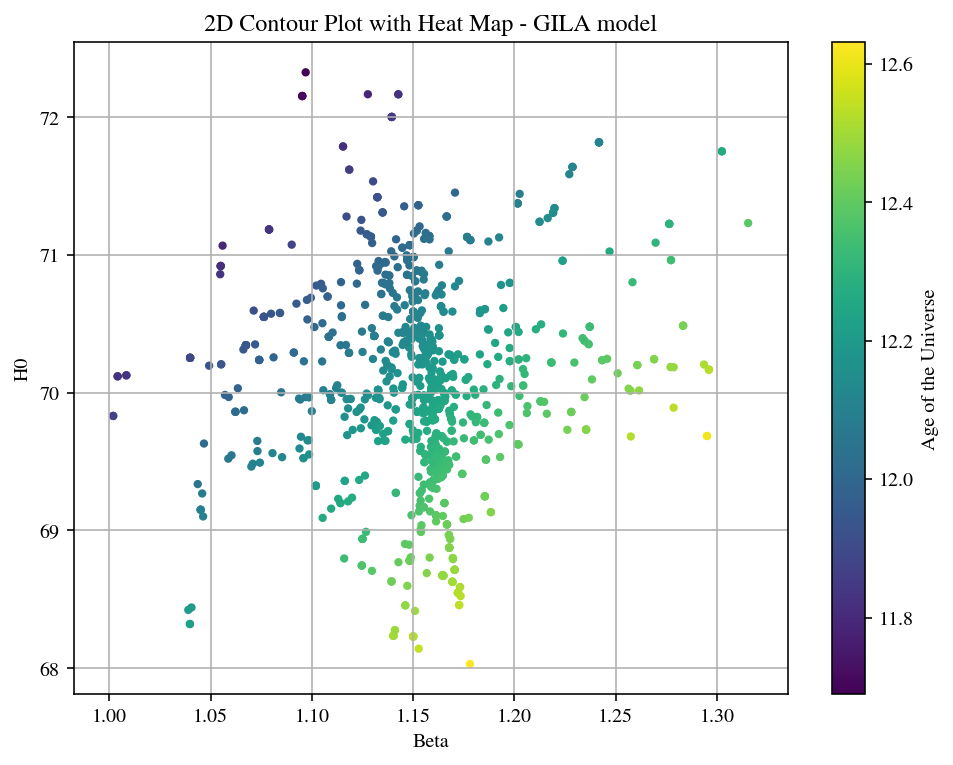

In [15]:
# Assuming flat_samples_beta contains the MCMC samples for beta and H0
beta_samples = flat_samples_gila[:, 1][:1000]
H0_samples = flat_samples_gila[:, 2][:1000]
ages = aou_gila

# Create MCSamples object for getdist
samples = MCSamples(samples=np.vstack([beta_samples, H0_samples]).T, names=['beta', 'H0'], labels=['\\beta', 'H_0'])

# Create a 2D contour plot
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True)

# Scatter plot with heat map
plt.figure(figsize=(8, 6))
plt.scatter(beta_samples, H0_samples, c=ages, cmap='viridis', s=10)
plt.colorbar(label='Age of the Universe')
plt.xlabel('Beta')
plt.ylabel('H0')
plt.title('2D Contour Plot with Heat Map - GILA model')
plt.grid(True)
plt.show()

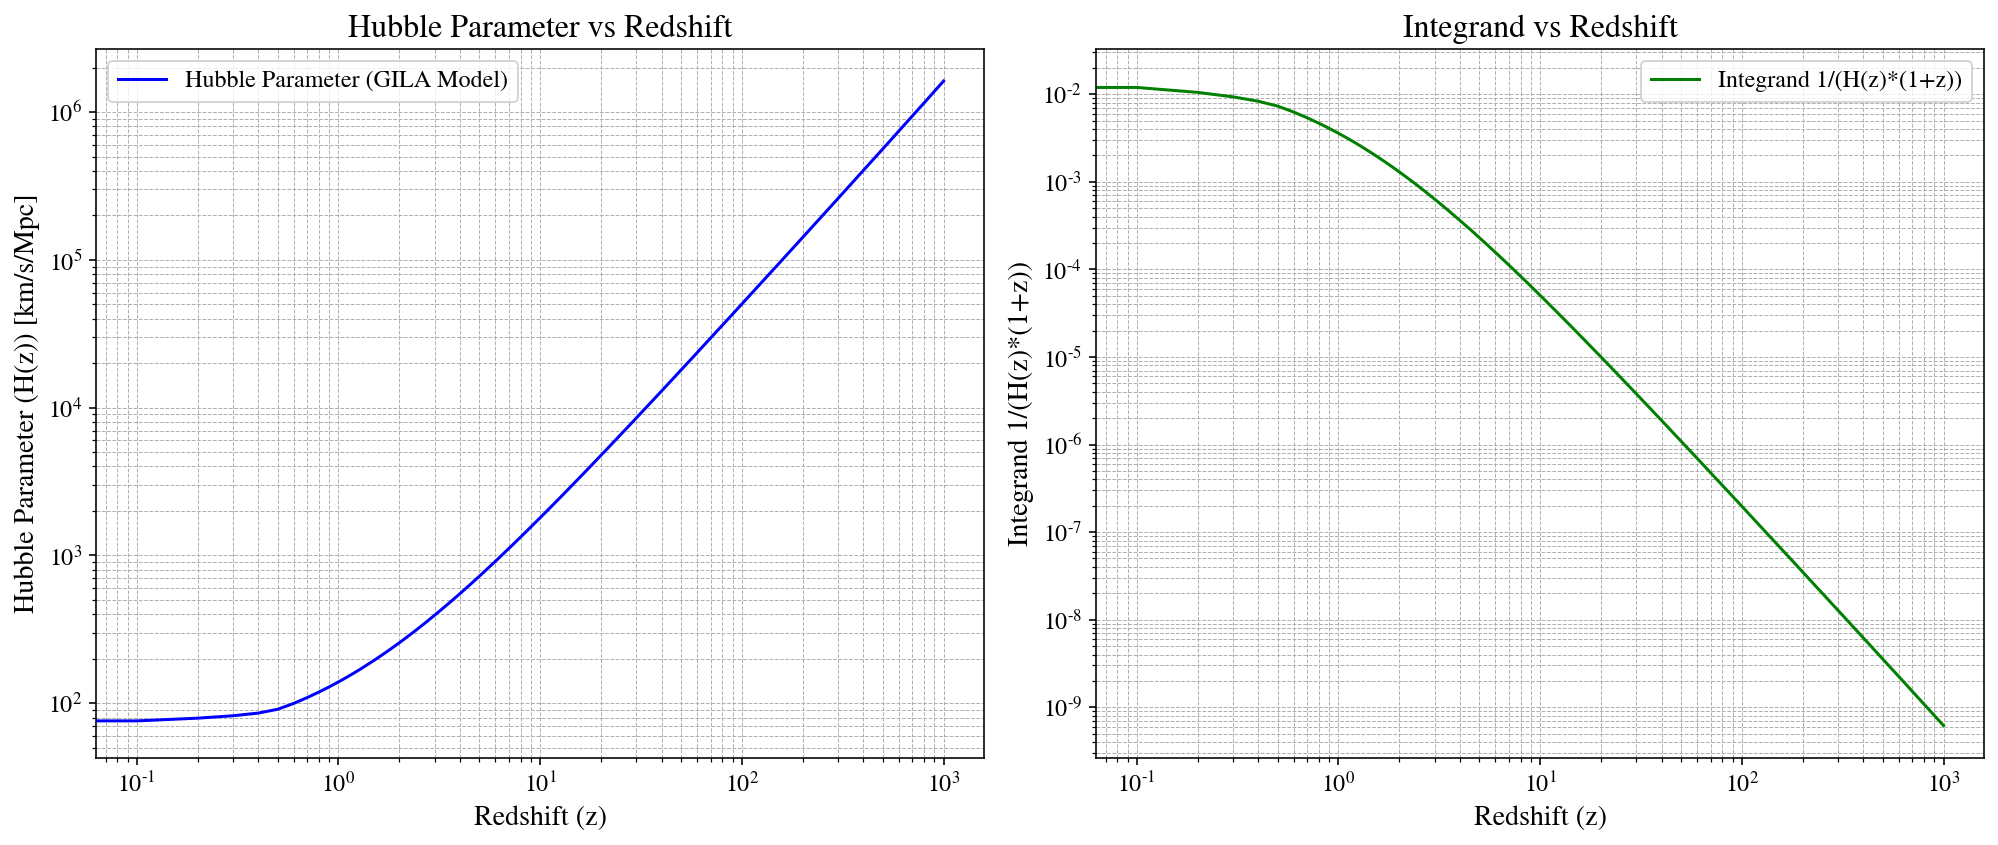

In [16]:
#GILA MODEL
#M_abs = flat_samples_beta[:,0]
beta = np.mean(flat_samples_gila[:,1])
H0 = np.mean(flat_samples_gila[:,2])

physical_params =  [L_bar, beta, H0] 
#physical_params =  [0.90, 0.3, 72] 
z_final, Hs_final = integrator_GILA(physical_params,model='GILA', num_z_points=int(len(z)),
                                    initial_z=z[0], final_z=z[-1]) #3 para z=1000

plot_hubble_parameter_subplots(z_final, Hs_final, model_name='GILA')

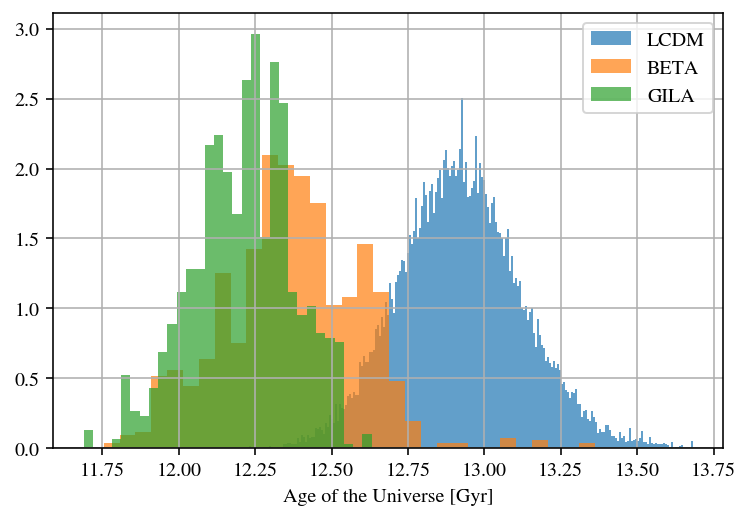

In [17]:
plt.figure()
plt.grid()
plt.hist(aou_lcdm, bins=int(np.sqrt(len(aou_lcdm))), density=True, alpha=0.7, label='LCDM')
plt.hist(aou_beta, bins=int(np.sqrt(len(aou_beta))), density=True, alpha=0.7, label='BETA')
plt.hist(aou_gila, bins=int(np.sqrt(len(aou_gila))), density=True, alpha=0.7, label='GILA')
plt.xlabel('Age of the Universe [Gyr]')
plt.legend()
os.chdir(path_figures)
plt.savefig('AOU_{}.pdf'.format(L_bar))

In [18]:
print('Length LCDM model:{}'.format(len(aou_lcdm)))
print('Length BETA model:{}'.format(len(aou_beta)))
print('Length GILA model:{}'.format(len(aou_gila)))

print('LCDM model: {:.5g} +/- {:.3g}'.format(np.mean(aou_lcdm), np.std(aou_lcdm)))
print('BETA model: {:.5g} +/- {:.3g}'.format(np.mean(aou_beta), np.std(aou_beta)))
print('GILA model: {:.5g} +/- {:.3g}'.format(np.mean(aou_gila), np.std(aou_gila)))

Length LCDM model:49680
Length BETA model:1000
Length GILA model:1000
LCDM model: 12.922 +/- 0.202
BETA model: 12.371 +/- 0.221
GILA model: 12.211 +/- 0.163


In [19]:
#LCDM MODEL


#z = np.linspace(0, 10, int(10e3))
z = np.linspace(0, 1000, int(10e3))
#z = np.logspace(-3, 3, int(10e3))

#Planck best fit
#omega_m = 0.1424 +/- 0.0011
#H0 = 67.4+/- 0.5

#omega_m = np.random.normal(loc=0.1424, scale=0.0011, size=1000)
#H0 = np.random.normal(loc=67.4, scale=0.5, size=1000)

#CC+PPS best fit
omega_m = np.random.normal(loc=0.163, scale=0.008, size=1000)
H0 = np.random.normal(loc=72.188, scale=0.85, size=1000)

#CC+PPS+SN best fit
#omega_m = np.random.normal(loc=0.159, scale=0.006, size=1000)
#H0 = np.random.normal(loc=72.392, scale=0.95, size=1000)

omega_r = OMEGA_R_0

#M_abs = flat_samples_lcdm[:,0]
#omega_m = flat_samples_lcdm[:,1]
#H0 = flat_samples_lcdm[:,2]

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
aou_lcdm = np.zeros(len(H0))

def aou_lcdm_calc(z, H0, Omega_r_lcdm, Omega_m_lcdm, Omega_L_lcdm):
    Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
    return inv_Hub_to_Gyr * simps(((1+z) * Hubble)**(-1), z) 

for i in range(len(aou_lcdm)):
    aou_lcdm[i] = aou_lcdm_calc(z, H0[i], Omega_r_lcdm[i], Omega_m_lcdm[i], Omega_L_lcdm[i])



LCDM model: 12.921 +/- 0.189


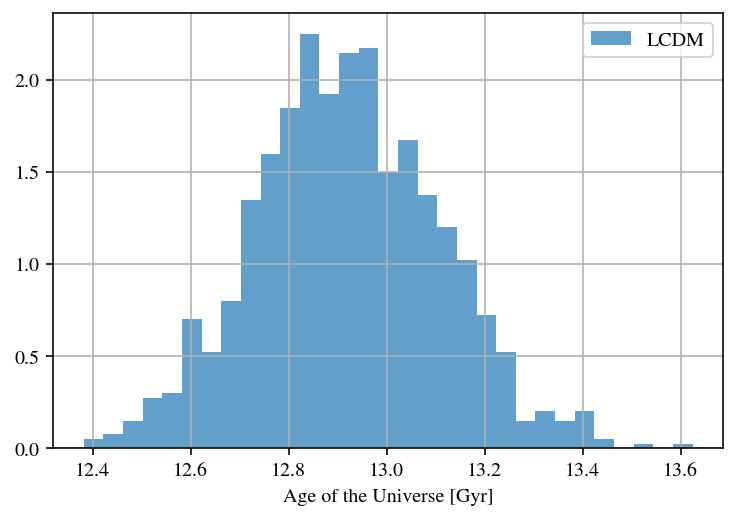

In [20]:
plt.figure()
plt.grid()
plt.hist(aou_lcdm, bins=int(np.sqrt(len(aou_lcdm))), density=True, alpha=0.7, label='LCDM')
plt.xlabel('Age of the Universe [Gyr]')
plt.legend()
os.chdir(path_figures)
plt.savefig('AOU_planck.pdf')

print('LCDM model: {:.5g} +/- {:.3g}'.format(np.mean(aou_lcdm), np.std(aou_lcdm)))

LCDM model: [0.16290042980084599, 72.18797371868]
Beta model: [0.9, 0.7440092509092732, 71.46984265327461]
Gila model: [0.9, 1.1754274708942443, 70.61033217553033]


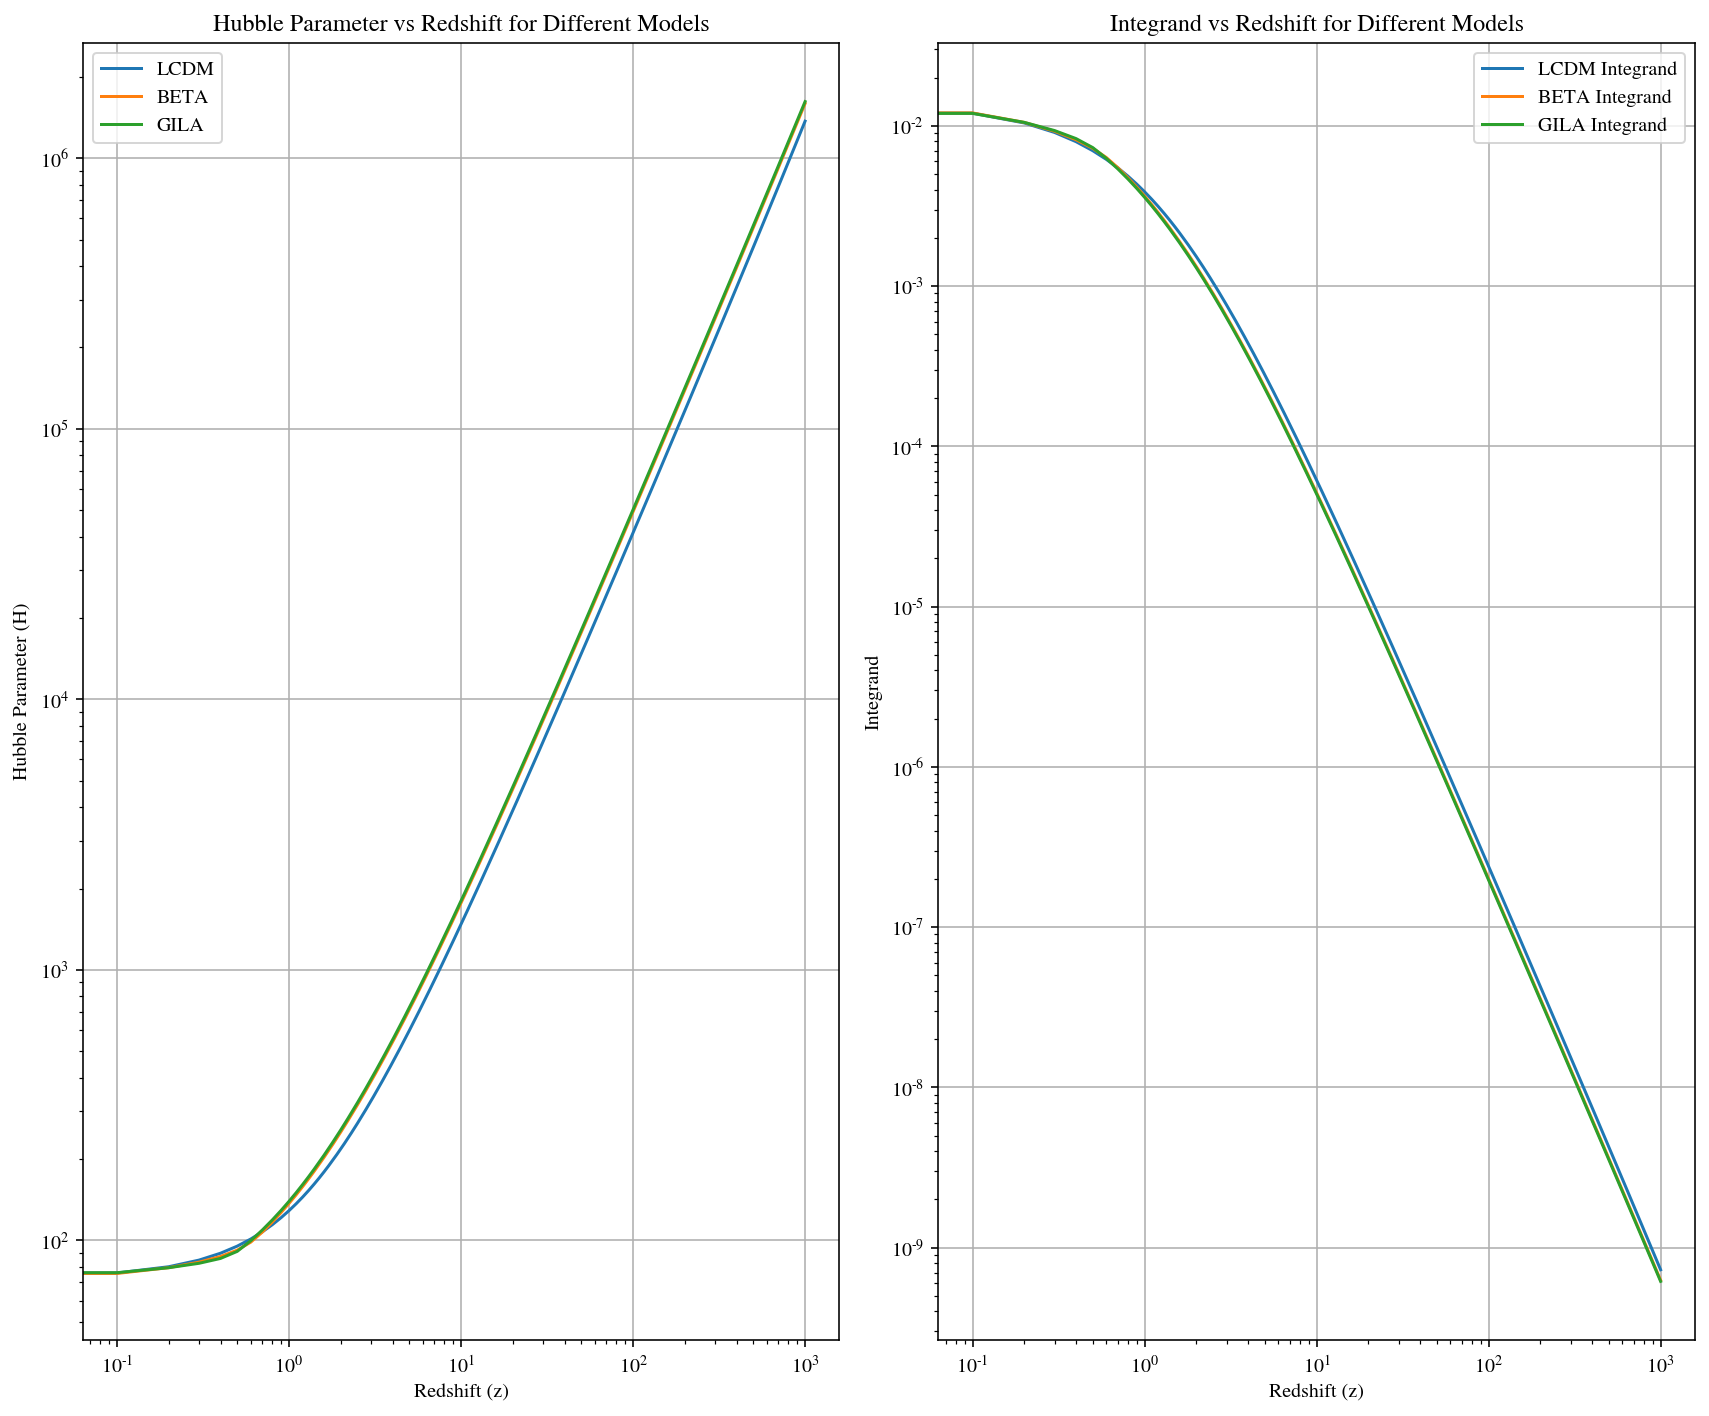

LCDM model: 12.916
BETA model: 12.253
GILA model: 12.164


In [21]:
import matplotlib.pyplot as plt
import numpy as np

#z = np.linspace(0, 10, int(10e3))
z = np.linspace(0, 1000, int(10e3))
#z = np.logspace(-3, 3, int(10e3))

#LCDM MODEL
omega_m = np.mean(flat_samples_lcdm[:,1])
H0_lcdm = np.mean(flat_samples_lcdm[:,2])

print('LCDM model: {}'.format([omega_m, H0_lcdm]))

Omega_r_lcdm = omega_r / (H0_lcdm/100)**2
Omega_m_lcdm = omega_m / (H0_lcdm/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

Hubble_lcdm = H0_lcdm * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )

#BETA MODEL
beta_beta = np.mean(flat_samples_beta[:,1])
H0_beta = np.mean(flat_samples_beta[:,2])

print('Beta model: {}'.format([L_bar, beta_beta, H0_beta]))

physical_params_beta =  [L_bar, beta_beta, H0_beta] 
z_final_beta, Hs_final_beta = integrator_GILA(physical_params_beta, model='BETA', num_z_points=int(len(z)),
                                              initial_z=z[0], final_z=z[-1])

#GILA MODEL
beta_gila = np.mean(flat_samples_gila[:,1])
H0_gila = np.mean(flat_samples_gila[:,2])

print('Gila model: {}'.format([L_bar, beta_gila, H0_gila]))

physical_params_gila =  [L_bar, beta_gila, H0_gila] 
z_final_gila, Hs_final_gila = integrator_GILA(physical_params_gila, model='GILA', num_z_points=int(len(z)),
                                              initial_z=z[0], final_z=z[-1])

# Plot all models on the same plot
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Hubble Parameter vs Redshift
axs[0].loglog(z, Hubble_lcdm, label='LCDM')
axs[0].loglog(z_final_beta, Hs_final_beta, label='BETA')
axs[0].loglog(z_final_gila, Hs_final_gila, label='GILA')
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('Hubble Parameter (H)')
axs[0].legend()
axs[0].set_title('Hubble Parameter vs Redshift for Different Models')
axs[0].grid(True)

# Integrand plot (example, replace with actual integrand calculation if needed)
integrand_lcdm = 1 / (H0_lcdm * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm) * (1+z))
integrand_beta = (Hs_final_beta * (1+z_final_beta))**(-1)
integrand_gila = (Hs_final_gila * (1+z_final_gila))**(-1)

axs[1].loglog(z, integrand_lcdm, label='LCDM Integrand')
axs[1].loglog(z_final_beta, integrand_beta, label='BETA Integrand')
axs[1].loglog(z_final_gila, integrand_gila, label='GILA Integrand')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_ylabel('Integrand')
axs[1].legend()
axs[1].set_title('Integrand vs Redshift for Different Models')
axs[1].grid(True)

plt.tight_layout()
plt.show()


aou_lcdm = inv_Hub_to_Gyr * simps(integrand_lcdm, z)
aou_beta = inv_Hub_to_Gyr * simps(integrand_beta, z_final_beta)
aou_gila = inv_Hub_to_Gyr * simps(integrand_gila, z_final_gila)
print('LCDM model: {:.5g}'.format(aou_lcdm))
print('BETA model: {:.5g}'.format(aou_beta))
print('GILA model: {:.5g}'.format(aou_gila))